## rappler news sentiment

TODO: 
* map company ticker to company name used in searching news websites
* currently rappler is only supported; expand to other news websites
* compare sentiments using nltk and textblob
  - nltk sentiment is "too" positive; all > 97%
  - no drastic change in previous sentiment leads to no buy signal
* incorporate trading strategy to fastquant.strategy module

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
from tqdm import tqdm
import time

import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from itertools import chain

sia = SentimentIntensityAnalyzer()

company_name = "Jollibee"
start_date = datetime.strptime("01-01-2018", "%m-%d-%Y").date()
base_url = "https://rappler.com"

all_posts = []
for page in range(1,4):
    #FIXME: url does not seem to work:
    #https://rappler.com/previous-articles?filterMeta=Jollibee&start=100
    time.sleep(1)
    url = base_url+f'/previous-articles?filterMeta={company_name}'
    if page>1:
        url+=f'&start={int(50*page)}'
    page = urlopen(url).read()
    soup = BeautifulSoup(page, features="html.parser")
    posts = soup.findAll("div", {"class": "col-xs-12 col-sm-8"})
    all_posts.append(posts)
#flatten list of list
all_posts = list(chain.from_iterable(all_posts))
len(all_posts)

150

In [2]:
date_sentiments = {}
for post in tqdm(all_posts): 
    #iterate all posts assuming items are sorted in published date
    time.sleep(1)
    url = post.a['href']
    #date = post.time.text
    date_string = post.span.text.split('-')[0].strip()
    date = datetime.strptime(date_string, '%b %d, %Y').date()
    print(date, base_url+url)
    if date>start_date:
        try:
            link_page = urlopen(base_url+url).read()
            link_soup = BeautifulSoup(link_page)
            sentences = link_soup.findAll("p")
            passage = ""
            for sentence in sentences:
                passage += sentence.text
            sentiment = sia.polarity_scores(passage)['compound']
            date_sentiments[date] = sentiment
        except Exception as e:
            print(e)
    else:
        #start date is reached
        break

  0%|          | 0/150 [00:00<?, ?it/s]

2020-05-28 https://rappler.com/business/262242-jollibee-earnings-report-q1-2020


  1%|          | 1/150 [00:02<05:22,  2.17s/it]

2020-04-18 https://rappler.com/life-and-style/best-eats/258322-jollibee-mango-graham-sundae-twirl-metro-manila-delivery


  1%|▏         | 2/150 [00:04<05:17,  2.15s/it]

2020-04-16 https://rappler.com/life-and-style/best-eats/258127-jollibee-amazing-aloha-yumburger-returns-menu


  2%|▏         | 3/150 [00:07<06:06,  2.49s/it]

2020-04-15 https://rappler.com/life-and-style/best-eats/257993-jollibee-iced-coffee-jelly-brown-sugar-milk-tea


  3%|▎         | 4/150 [00:09<05:46,  2.37s/it]

2020-04-13 https://rappler.com/business/257810-singapore-fines-jollibee-branch-violating-safe-distancing-rules-coronavirus


  3%|▎         | 5/150 [00:11<05:33,  2.30s/it]

2020-03-28 https://rappler.com/life-and-style/best-eats/256173-jollibee-ready-to-cook-menu-limited-time-only


  4%|▍         | 6/150 [00:13<05:23,  2.24s/it]

2020-03-19 https://rappler.com/business/255184-employees-thank-jollibee-salary-coronavirus-luzon-lockdown


  5%|▍         | 7/150 [00:16<05:19,  2.24s/it]

2020-03-13 https://rappler.com/brandrap/goodrap/254222-jollibee-senior-citizens-differently-abled-service-crew


  5%|▌         | 8/150 [00:18<05:15,  2.22s/it]

2020-02-18 https://rappler.com/business/252116-jollibee-earnings-report-2019


  6%|▌         | 9/150 [00:20<05:06,  2.18s/it]

2020-02-10 https://rappler.com/life-and-style/best-eats/251409-jollibee-spicy-tuna-pie


  7%|▋         | 10/150 [00:22<04:59,  2.14s/it]

2020-01-15 https://rappler.com/brandrap/travel-food-and-lifestyle/248616-jollibee-level-up-joy-petron-slex-branch


  7%|▋         | 11/150 [00:27<06:42,  2.90s/it]

2020-01-03 https://rappler.com/business/248462-jollibee-new-branches-united-states-canada


  8%|▊         | 12/150 [00:30<07:18,  3.18s/it]

2020-01-02 https://rappler.com/life-and-style/best-eats/248419-jollibee-phase-out-champ-burgers


  9%|▊         | 13/150 [00:35<08:06,  3.55s/it]

2019-12-01 https://rappler.com/life-and-style/1019-lifestyle/246159-jollibee-hetty-funko-pop


  9%|▉         | 14/150 [00:38<07:53,  3.48s/it]

2019-11-22 https://rappler.com/brandrap/travel-food-and-lifestyle/245504-jollibee-level-up-joy-store-katipunan


 10%|█         | 15/150 [00:42<08:06,  3.61s/it]

2019-11-21 https://rappler.com/brandrap/announcements/245476-jollibee-self-order-kiosks


 11%|█         | 16/150 [00:44<07:04,  3.17s/it]

2019-11-15 https://rappler.com/brandrap/announcements/244925-mang-inasal-opens-600th-store


 11%|█▏        | 17/150 [00:48<07:25,  3.35s/it]

2019-11-14 https://rappler.com/business/244906-jollibee-to-operate-tim-ho-wan-china


 12%|█▏        | 18/150 [00:51<07:25,  3.37s/it]

2019-11-04 https://rappler.com/life-and-style/best-eats/244096-jollibee-breakfast-pie-cheesy-bacon-corned-beef


 13%|█▎        | 19/150 [00:56<08:07,  3.72s/it]

2019-10-15 https://rappler.com/life-and-style/best-eats/242600-jollibee-menu-buko-pie


 13%|█▎        | 20/150 [00:58<06:58,  3.22s/it]

2019-09-01 https://rappler.com/life-and-style/travel/239057-department-of-tourism-jollibee-eats-more-fun-campaign


 14%|█▍        | 21/150 [01:02<07:28,  3.48s/it]

2019-08-31 https://rappler.com/life-and-style/best-eats/238982-jollibee-crispy-spice-fries-bacon-cheese-yumburger


 15%|█▍        | 22/150 [01:07<08:17,  3.89s/it]

2019-08-23 https://rappler.com/nation/238383-isko-moreno-fast-food-chains-sign-pact-employ-senior-citizens-pwds


 15%|█▌        | 23/150 [01:12<08:59,  4.25s/it]

2019-08-05 https://rappler.com/business/237105-jollibee-earnings-report-january-june-2019


 16%|█▌        | 24/150 [01:16<08:39,  4.12s/it]

2019-07-29 https://rappler.com/business/236496-jollibee-stocks-to-watch-july-29-august-2-2019


 17%|█▋        | 25/150 [01:18<07:30,  3.61s/it]

2019-07-24 https://rappler.com/business/236220-jollibee-shares-drop-news-coffee-bean-acquisition


 17%|█▋        | 26/150 [01:20<06:35,  3.19s/it]

2019-07-24 https://rappler.com/business/236169-jollibee-investment-acquire-coffee-bean-tea-leaf-brand


 18%|█▊        | 27/150 [01:24<07:00,  3.42s/it]

2019-06-11 https://rappler.com/life-and-style/1019-lifestyle/232789-jollibee-funko-pop-wearing-philippine-barong-independence-day-2019


 19%|█▊        | 28/150 [01:28<07:03,  3.47s/it]

2019-04-06 https://rappler.com/business/227569-photo-jollibee-open-guam-april-2109


 19%|█▉        | 29/150 [01:32<07:32,  3.74s/it]

2019-02-14 https://rappler.com/business/223504-jollibee-earnings-report-2018


 20%|██        | 30/150 [01:37<08:16,  4.13s/it]

2018-12-27 https://rappler.com/nation/219752-jollibee-to-regularize-3000-workers-yearly


 21%|██        | 31/150 [01:39<06:57,  3.51s/it]

2018-12-17 https://rappler.com/business/219104-dole-report-number-regularized-workers-by-sm-2018


 21%|██▏       | 32/150 [01:41<06:01,  3.06s/it]

2018-12-09 https://rappler.com/newsbreak/inside-track/218568-leni-robredo-statement-destabilization-plot-paolo-duterte


 22%|██▏       | 33/150 [01:44<05:26,  2.79s/it]

2018-10-31 https://rappler.com/life-and-style/best-eats/215633-photos-jollibee-manhattan-new-york


 23%|██▎       | 34/150 [01:46<05:00,  2.59s/it]

2018-10-21 https://rappler.com/life-and-style/best-eats/214803-in-photos-lines-at-jollibee-in-uk


 23%|██▎       | 35/150 [01:48<04:45,  2.48s/it]

2018-10-18 https://rappler.com/life-and-style/best-eats/214619-jollibee-first-store-united-kingdom-opening-october-2018


 24%|██▍       | 36/150 [01:50<04:35,  2.42s/it]

2018-09-29 https://rappler.com/business/212980-jollibee-london-shows-philippine-business-can-go-global


 25%|██▍       | 37/150 [01:52<04:24,  2.34s/it]

2018-09-26 https://rappler.com/business/212869-jollibee-store-london-opening-october-20-2018


 25%|██▌       | 38/150 [01:56<04:56,  2.65s/it]

2018-07-27 https://rappler.com/life-and-style/arts-and-culture/208339-jollibee-funko-pop-asiapop-comicon-2018


 26%|██▌       | 39/150 [01:58<04:41,  2.53s/it]

2018-07-24 https://rappler.com/life-and-style/best-eats/208125-jollibee-bistek-burger-steak


 27%|██▋       | 40/150 [02:00<04:22,  2.39s/it]

2018-06-30 https://rappler.com/nation/206124-the-week-in-photos-june-23-29-2018


 27%|██▋       | 41/150 [02:02<04:10,  2.30s/it]

2018-06-28 https://rappler.com/life-and-style/205992-jollibee-funko-pop-collectibles-july-2018


 28%|██▊       | 42/150 [02:04<04:02,  2.25s/it]

2018-05-28 https://rappler.com/video/newscast/203565-thewrap-may-28-2018-evening-edition


 29%|██▊       | 43/150 [02:06<03:54,  2.19s/it]

2018-05-28 https://rappler.com/nation/203529-jollibee-dole-pldt-labor-only-contracting


 29%|██▉       | 44/150 [02:09<03:52,  2.19s/it]

2018-05-10 https://rappler.com/the-wrap/202165-daily-news-highlights-may-10-2018-edition


 30%|███       | 45/150 [02:11<03:48,  2.18s/it]

2018-05-09 https://rappler.com/business/202127-jollibee-foods-tim-ho-wan-titan-dining-lp


 31%|███       | 46/150 [02:13<03:40,  2.12s/it]

2018-05-09 https://rappler.com/technology/news/202116-jollibee-delivery-websites-chowking-greenwich-red-ribbon-suspended


 31%|███▏      | 47/150 [02:15<03:37,  2.11s/it]

2018-05-09 https://rappler.com/the-wrap/202091-daily-news-highlights-may-9-2018-edition


 32%|███▏      | 48/150 [02:17<03:32,  2.08s/it]

2018-05-08 https://rappler.com/technology/news/202061-national-privacy-commission-jollibee-delivery-website-suspension


 33%|███▎      | 49/150 [02:19<03:27,  2.06s/it]

2018-04-05 https://rappler.com/the-wrap/199596-daily-news-highlights-april-5-2018-edition


 33%|███▎      | 50/150 [02:21<03:24,  2.04s/it]

2016-05-31 https://rappler.com/life-and-style/best-eats/134868-jollibee-adobo-flakes-burger-halo-halo-sundae


In [3]:
date_sentiments

{datetime.date(2020, 5, 28): 0.9623,
 datetime.date(2020, 4, 18): 0.9761,
 datetime.date(2020, 4, 16): 0.9947,
 datetime.date(2020, 4, 15): 0.9774,
 datetime.date(2020, 4, 13): 0.9905,
 datetime.date(2020, 3, 28): 0.9903,
 datetime.date(2020, 3, 19): 0.9962,
 datetime.date(2020, 3, 13): 0.9996,
 datetime.date(2020, 2, 18): 0.9919,
 datetime.date(2020, 2, 10): 0.981,
 datetime.date(2020, 1, 15): 0.9991,
 datetime.date(2020, 1, 3): 0.9905,
 datetime.date(2020, 1, 2): 0.9978,
 datetime.date(2019, 12, 1): 0.9855,
 datetime.date(2019, 11, 22): 0.9999,
 datetime.date(2019, 11, 21): 0.9991,
 datetime.date(2019, 11, 15): 0.9981,
 datetime.date(2019, 11, 14): 0.9904,
 datetime.date(2019, 11, 4): 0.9897,
 datetime.date(2019, 10, 15): 0.9775,
 datetime.date(2019, 9, 1): 0.9977,
 datetime.date(2019, 8, 31): 0.9956,
 datetime.date(2019, 8, 23): 0.9897,
 datetime.date(2019, 8, 5): 0.9925,
 datetime.date(2019, 7, 29): 0.9874,
 datetime.date(2019, 7, 24): 0.9923,
 datetime.date(2019, 6, 11): 0.9966,
 

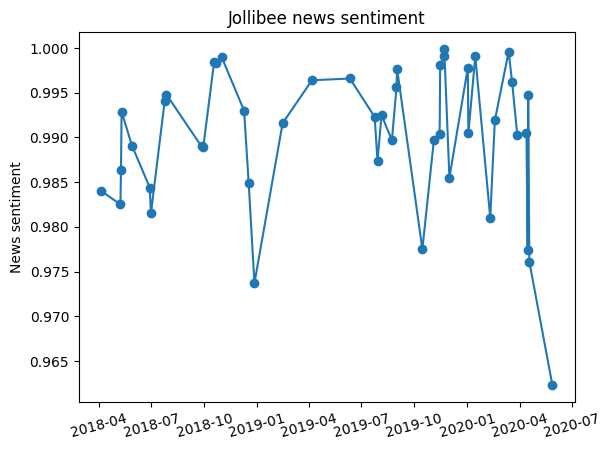

In [6]:
import pandas as pd
import matplotlib.pyplot as pl
pl.style.use("default")

s = pd.Series(date_sentiments)
ax = s.plot(marker='o')
ax.set_ylabel("News sentiment")
ax.set_title(f"{company_name} news sentiment")
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

Starting Portfolio Value: 100000.00
0.984
0.9825
0.9864
0.9929
0.9844
0.9941
0.9948
0.989
0.9985
0.999
0.9849
0.9737
0.9916
0.9966
0.9923
0.9874
0.9925
0.9897
0.9775
0.9897
0.9904
0.9981
0.9991
0.9999
0.9978
0.9905
0.9991
0.981
0.9919
0.9996
0.9962
0.9905
0.9774
0.9947
0.9623
None
None
None
None
None
None
None
None
None
0.9825
0.9864
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9929
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9844
0.9941
0.9941
0.9941
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948
0.9948

<IPython.core.display.Javascript object>


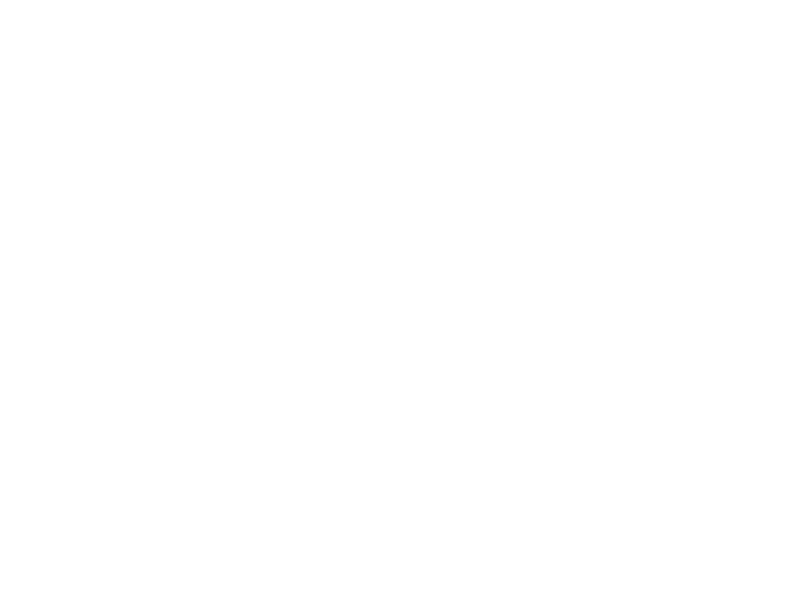

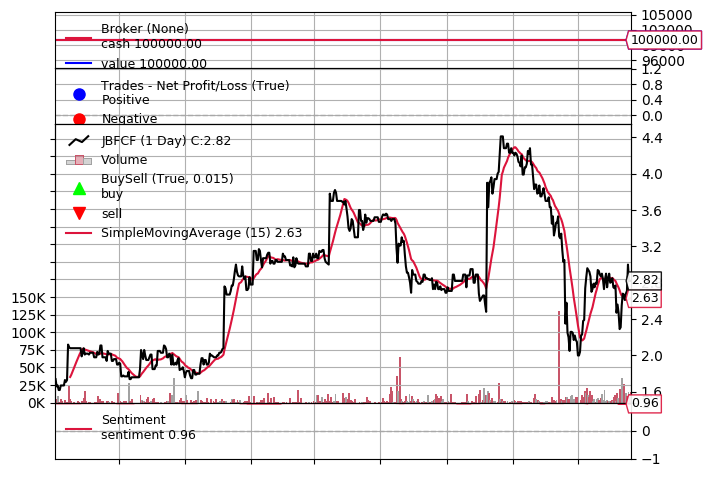

In [7]:
from __future__ import (absolute_import, division, print_function,
                            unicode_literals)
import matplotlib.pyplot as pl
pl.style.use("default")

import backtrader as bt
import backtrader.indicators as btind
from datetime import datetime
import os.path
import sys

verbose = False

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiments:
            print(date_sentiments[date])
            self.sentiment = date_sentiments[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        if verbose:
            self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiments:
            self.sentiment = date_sentiments[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        print(self.sentiment)
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)
        
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'JBFCF',
        fromdate = min(date_sentiments.keys()),
        todate = datetime.now().date(),
        reverse = False
    )
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()